# Surface Mass Balance: XGB 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

#### Load KM_L 

In [2]:
df = pd.read_csv('data/promice/preprocessed/daily/SCO_L.csv')

##### Pre-processing

In [3]:
# Fill NA values in Melting season as blank
df['Melting Season'] = df['Melting Season'].fillna('No Ablation')

In [4]:
#Remove all NA values if training should be done only on ablation
#df = df.dropna()

# Remove only values from Wind direction if training should be done on entire dataset
df = df[df['Wind from direction (upper boom)'].notna()] 

df = df.reset_index(drop=True)

In [5]:
# This bit retrieve the indexes for all melting season categories and remove column from df
for category in ['pre', 'beginning', 'middle', 'end']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

indices_all = df[df['Ablation'].isin([True, False])].index

In [6]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['Melting Season'] = le.fit_transform(df['Melting Season'])
label_dict = dict(zip(le.classes_, le.transform(le.classes_)))
label_dict

{'No Ablation': 0, 'beginning': 1, 'end': 2, 'middle': 3, 'pre': 4}

In [7]:
# This bit to include only relevant features
exclude_list = [                                                    'index', # excluded because of unimportant information
                                                                     'stid', # excluded because of unimportant information
                                                               'Unnamed: 0', # Old Index
                                                                 'Ablation',
                                                          # 'Melting Season', # We drop melting season later 
                                              'year', 'month','day', 'hour', # Drop because of sin & cos values
                                                                 'subgroup',
                'Surface height from combined measurements',
                'Surface height from combined measurements DELTA'
               ]

df = df[[column for column in df.columns if column not in exclude_list]]


In [8]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.strftime('%Y-%m-%d')

df['Datetime'] = pd.to_datetime(df['Datetime'])

#Create new columns
#df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
#df['day'] = df['Datetime'].dt.day
#df['hour'] = df['Datetime'].dt.hour

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

In [9]:
# This bit to change the datetime variables into a form that a ML models can understand (continued)
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html 

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# with year
#cyclical = cyclical.fit_transform(df[['month', 'year', 'Wind from direction (upper boom)']]) 

# without year
cyclical = cyclical.fit_transform(df[['month', 'Wind from direction (upper boom)']]) 
df = pd.merge(df, cyclical, left_index=True, right_index=True)

df.drop(columns=['month', 'Wind from direction (upper boom)'], inplace=True)

In [10]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# with year
#num_cols = df.select_dtypes(include=['int64','float64']).drop(['Surface height from combined measurements', 'Surface height from combined measurements DELTA','month_sin','month_cos','year_sin','year_cos','Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos', 'Melting Season'], axis=1).columns #select numerical columns except y and cyclical feature

# without year
num_cols = df.select_dtypes(include=['int64','float64']).drop(['month_sin','month_cos','Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos', 'Melting Season'], axis=1).columns #select numerical columns except y and cyclical feature

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [11]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# split the data into training and testing sets while maintaining the subgroup distribution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split.split(df, df['Melting Season']):
    train = df.loc[train_index]
    test = df.loc[test_index]

# separate the features and target variables for the train and test sets
X_train = train.drop(['Melting Season'], axis=1)
y_train = train['Melting Season']
X_test = test.drop(['Melting Season'], axis=1)
y_test = test['Melting Season']



## XGB Regression

In [12]:
# Import required libraries
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [13]:
# This bit to find best XBG Regressor model for when Ablation == True and for both target variables

indices = eval(f"indices_all")  # Get the indices for the current category

# Find common indexes
X_Train_valid_indices = indices.intersection(X_train.index)
y_Train_valid_indices = indices.intersection(y_train.index)
X_Test_valid_indices = indices.intersection(X_test.index)
y_Test_valid_indices = indices.intersection(y_test.index)

# filter out by indeces
X_train_category = X_train.loc[X_Train_valid_indices]  
y_train_category = y_train.loc[y_Train_valid_indices] 
X_test_category = X_test.loc[X_Test_valid_indices]  
y_test_category = y_test.loc[y_Test_valid_indices]

# Define the XGBClassifier model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=5)

# Define the hyperparameter grid for tuning
param_grid = {
    'max_depth': [3], #[3, 4, 5],
    'learning_rate': [0.01], #[0.01, 0.1, 0.3],
    'n_estimators': [100], #[100, 200, 500],
    'min_child_weight': [1], #[1, 3, 5],
    'gamma': [0], #[0, 0.1, 0.3],
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=5, n_jobs=-1, verbose=0)

# Fit the grid search object to the training data
grid_search.fit(X_train_category, y_train_category)

# Print the best hyperparameters and the corresponding accuracy score on the test set
print("Best hyperparameters: ", grid_search.best_params_)
y_pred_category = grid_search.predict(X_test_category)
print("Accuracy score on test set: ", accuracy_score(y_test_category, y_pred_category))
print("F1 score on test set: ", f1_score(y_test_category, y_pred_category, average='weighted'))

labels = [k for k, v in sorted(label_dict.items(), key=lambda item: item[1])]
cm = confusion_matrix(y_test_category, y_pred_category)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print("Confusion matrix on test set: ")
print(cm_df)


# Save the best model parameters as 'model' variable
model = grid_search.best_estimator_

Best hyperparameters:  {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Accuracy score on test set:  0.93519882179676
F1 score on test set:  0.9340593798367753
Confusion matrix on test set: 
             No Ablation  beginning  end  middle  pre
No Ablation          524          0    4       8    1
beginning              0         35    0      21    0
end                   15          0   35       8    0
middle                 1          5    7     244    0
pre                    2         10    0       6  432


In [115]:
for category in ['pre', 'beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(X_train.index)
    y_Train_valid_indices = indices.intersection(y_train.index)
    X_Test_valid_indices = indices.intersection(X_test.index)
    y_Test_valid_indices = indices.intersection(y_test.index)

    # filter out by indeces
    X_train_category = X_train.loc[X_Train_valid_indices]
    y_train_category = y_train.loc[y_Train_valid_indices]
    X_test_category = X_test.loc[X_Test_valid_indices]
    y_test_category = y_test.loc[y_Test_valid_indices]

    # Apply XGB on all periods  
    #model.fit(X_train_category, y_train_category)  # Fit a new model on each subset
    y_pred_category = model.predict(X_test_category)
    
    print(f"Accuracy score on test set {category}: ", accuracy_score(y_test_category, y_pred_category))
    print(f"F1 score on test set {category}: ", f1_score(y_test_category, y_pred_category, average='weighted'))

    print(f"Confusion matrix on test set {category}: ")
    print(model.get_booster().get_score(importance_type= f))

Accuracy score on test set pre:  0.96
F1 score on test set pre:  0.9795918367346939
Confusion matrix on test set pre: 
{'Air pressure (upper boom)': 4.827918529510498, 'Air temperature (upper boom)': 6.169401168823242, 'Specific humidity (upper boom)': 8.519200325012207, 'Wind speed (upper boom)': 4.558736801147461, 'Downwelling shortwave radiation - corrected': 73.06398010253906, 'Upwelling shortwave radiation - corrected': 124.67742156982422, 'Downwelling longwave radiation': 3.4092586040496826, 'Upwelling longwave radiation': 11.474056243896484, 'Surface temperature': 222.55130004882812, 'Sensible heat flux (upper boom)': 5.463080883026123, 'Albedo': 21.84328842163086, 'Cloud cover': 7.209012031555176, 'month_sin': 124.41825103759766, 'month_cos': 317.2082824707031, 'Wind from direction (upper boom)_sin': 7.312184810638428, 'Wind from direction (upper boom)_cos': 3.5413403511047363}
Accuracy score on test set beginning:  0.625
F1 score on test set beginning:  0.7692307692307693
Conf

In [64]:
df[df['Melting Season'] == 3]

,Air pressure (upper boom),Air temperature (upper boom),Relative humidity (upper boom) - corrected,Specific humidity (upper boom),Wind speed (upper boom),Downwelling shortwave radiation - corrected,Upwelling shortwave radiation - corrected,Downwelling longwave radiation,Upwelling longwave radiation,Surface temperature,Latent heat flux (upper boom),Sensible heat flux (upper boom),Albedo,Cloud cover,Melting Season,month_sin,month_cos,Wind from direction (upper boom)_sin,Wind from direction (upper boom)_cos
0,0.487301,0.823685,0.632328,0.679327,0.189520,0.606533,0.243259,0.747067,0.938960,0.998389,0.791036,0.276460,0.058874,0.583879,3,-9.848078e-01,0.173648,0.998923,-0.046390
1,0.467779,0.885606,0.553944,0.701633,0.229952,0.529323,0.200665,0.778293,0.955979,1.000000,0.782539,0.298192,0.047677,0.536027,3,-9.848078e-01,0.173648,0.996813,0.079771
2,0.548448,0.828361,0.727032,0.729125,0.188192,0.453813,0.170827,0.835722,0.945571,1.000000,0.795939,0.238237,0.050251,0.760744,3,-9.848078e-01,0.173648,0.999009,0.044519
3,0.478614,0.870245,0.524048,0.657856,0.335451,0.723119,0.287402,0.630888,0.943749,1.000000,0.744059,0.428781,0.045781,0.253325,3,-9.848078e-01,0.173648,0.898254,0.439478
4,0.466346,0.875845,0.523715,0.669650,0.361645,0.676684,0.267868,0.649181,0.946179,1.000000,0.754016,0.461043,0.039957,0.281933,3,-9.848078e-01,0.173648,0.872807,0.488066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,0.612372,0.871126,0.695471,0.786688,0.437389,0.287736,0.131252,0.723144,0.950593,0.999937,0.887510,0.566564,0.127509,0.447167,3,-2.449294e-16,1.000000,0.349015,0.937117
2045,0.577283,0.860826,0.736479,0.798206,0.209268,0.139421,0.069374,0.703632,0.967297,0.998435,0.821008,0.357253,0.288320,0.425844,3,-2.449294e-16,1.000000,0.606503,0.795081
2046,0.623102,0.790213,1.000000,0.832806,0.123590,0.031926,0.017441,0.901885,0.960020,1.000000,0.817613,0.191004,0.394501,0.945221,3,-2.449294e-16,1.000000,0.765355,0.643609
2047,0.689016,0.817874,0.632661,0.636314,0.300612,0.168881,0.116935,0.750266,0.959211,0.999794,0.696706,0.337182,0.363809,0.600385,3,-2.449294e-16,1.000000,0.354584,0.935024


## Filter by Melting Season

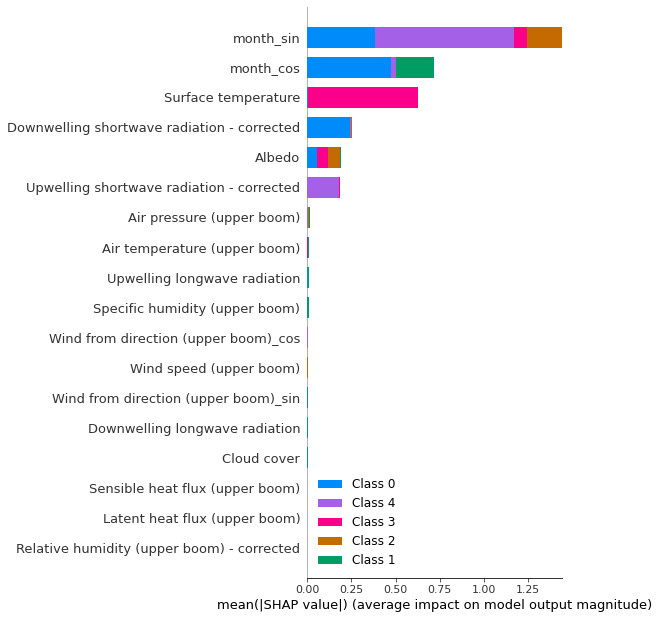

In [31]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test,approximate=True)
shap.summary_plot(shap_values, X_test, plot_type="bar")

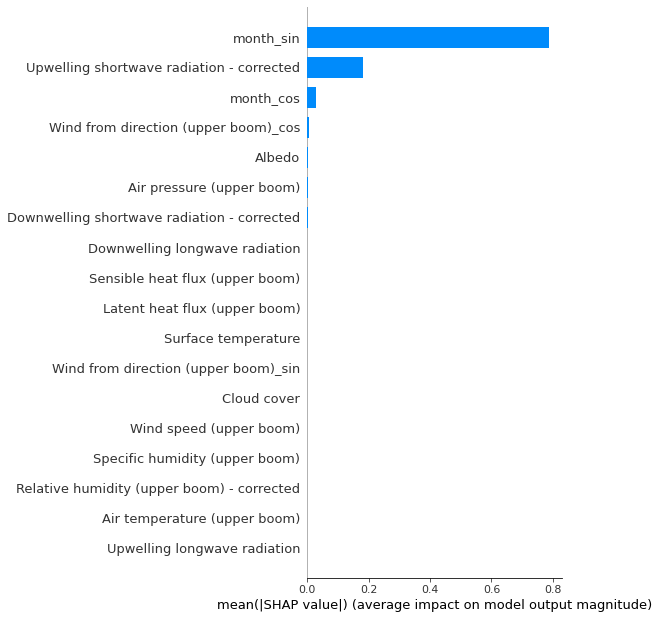

In [41]:
shap.summary_plot(shap_values[4], X_test, plot_type="bar")

In [25]:
explainer

In [23]:
y_test_category[y_test_category == 4]

149     4
155     4
167     4
170     4
171     4
       ..
4267    4
4270    4
4272    4
4275    4
4278    4
Name: Melting Season, Length: 450, dtype: int64

In [24]:
y_test_category

6       3
9       3
11      3
24      3
25      3
       ..
4508    0
4509    0
4521    0
4522    0
4524    0
Name: Melting Season, Length: 1358, dtype: int64

In [19]:
shap_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.000233,0.000716,0.0,0.000488,0.0,0.004276,0.009273,0.000000,0.003736,0.017914,0.0,0.000034,0.023146,0.000123,0.129422,0.023011,0.000054,0.000538
1,0.000100,0.000796,0.0,0.000325,0.0,0.003945,0.007907,0.000000,0.003530,0.018477,0.0,0.000000,0.021667,0.000050,0.129443,0.024655,0.000067,0.000494
2,0.000271,0.000839,0.0,0.000468,0.0,0.002828,0.009689,0.000000,0.003668,0.017659,0.0,0.000000,0.022417,0.000053,0.131060,0.024904,0.000060,0.000551
3,0.000436,0.000815,0.0,0.000409,0.0,0.006206,0.008540,0.000000,0.000488,0.018082,0.0,0.000000,0.021065,0.000052,0.130334,0.025133,0.000094,0.000457
4,0.001240,0.000686,0.0,0.000474,0.0,0.008988,0.008896,0.000000,0.000367,0.018577,0.0,0.000000,0.019662,0.000093,0.134391,0.024002,0.000054,0.000585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,0.000126,0.000313,0.0,0.000971,0.0,0.025572,0.119613,0.001803,0.001488,0.002594,0.0,0.000083,0.006547,0.000133,0.054830,0.047850,0.000058,0.000645
1354,0.000156,0.000282,0.0,0.001099,0.0,0.027307,0.115884,0.001111,0.001683,0.003234,0.0,0.000084,0.008093,0.000124,0.054613,0.050729,0.000037,0.000588
1355,0.000447,0.000427,0.0,0.000907,0.0,0.025228,0.110261,0.000247,0.001953,0.003010,0.0,0.000000,0.006332,0.000035,0.044501,0.045998,0.000042,0.000657
1356,0.000372,0.000140,0.0,0.001091,0.0,0.024179,0.112501,0.001500,0.001528,0.002875,0.0,0.000060,0.006444,0.000056,0.048266,0.050283,0.000033,0.000612


In [124]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier


# Split the test set into subsets for each class
class_subsets = {}
for c in np.unique(y_test_category):
    class_subsets[c] = X_test_category[y_test_category == c]

# Calculate feature importance for each class
class_feature_importances = {}
for c in class_subsets:
    # Get predicted probabilities for the current class subset
    y_pred_proba = model.predict_proba(class_subsets[c])

    # Calculate feature importance for the current class
    feature_importances = model.feature_importances_
    class_feature_importances[c] = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})

# Print the feature importance for each class
for c in class_feature_importances:
    print(f"Class {c} feature importance:")
    print(class_feature_importances[c])


Class 0 feature importance:
                                        feature  importance
0                     Air pressure (upper boom)    0.005102
1                  Air temperature (upper boom)    0.006520
2    Relative humidity (upper boom) - corrected    0.000000
3                Specific humidity (upper boom)    0.009003
4                       Wind speed (upper boom)    0.004818
5   Downwelling shortwave radiation - corrected    0.077215
6     Upwelling shortwave radiation - corrected    0.131760
7                Downwelling longwave radiation    0.003603
8                  Upwelling longwave radiation    0.012126
9                           Surface temperature    0.235194
10                Latent heat flux (upper boom)    0.000000
11              Sensible heat flux (upper boom)    0.005773
12                                       Albedo    0.023084
13                                  Cloud cover    0.007619
14                                    month_sin    0.131486
15          

In [125]:
y_pred_proba

array([[0.4941356 , 0.07613831, 0.0761558 , 0.07650229, 0.27706796],
       [0.09523334, 0.09444961, 0.0944713 , 0.09490112, 0.6209447 ],
       [0.09523334, 0.09444961, 0.0944713 , 0.09490112, 0.6209447 ],
       ...,
       [0.09541752, 0.09443039, 0.09445207, 0.09488181, 0.6208183 ],
       [0.09541752, 0.09443039, 0.09445207, 0.09488181, 0.6208183 ],
       [0.09130052, 0.09035597, 0.09037672, 0.13393521, 0.5940317 ]],
      dtype=float32)

## LSTM

In [313]:
# This bit to find best LSTM model for when Ablation == True and for both target variables

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

for i in ["delta","absolute"]:
    
    indices = eval(f"indices_ablation")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(eval(f"X_{i}_train").index)
    y_Train_valid_indices = indices.intersection(eval(f"y_{i}_train").index)
    X_Test_valid_indices = indices.intersection(eval(f"X_{i}_test").index)
    y_Test_valid_indices = indices.intersection(eval(f"y_{i}_test").index)

    # filter out by indeces
    X_train_category = eval(f"X_{i}_train").loc[X_Train_valid_indices]  
    y_train_category = eval(f"y_{i}_train").loc[y_Train_valid_indices] 
    X_test_category = eval(f"X_{i}_test").loc[X_Test_valid_indices]  
    y_test_category = eval(f"y_{i}_test").loc[y_Test_valid_indices]
    
    # Impute missing values
    X_train_category = X_train_category.fillna(X_train_category.mean())
    y_train_category = y_train_category.fillna(y_train_category.mean())
    X_test_category = X_test_category.fillna(X_test_category.mean())

    
    # Reshape the input data to 3D array
    X_train_category = X_train_category.values.reshape((X_train_category.shape[0], 1, X_train_category.shape[1]))
    X_test_category = X_test_category.values.reshape((X_test_category.shape[0], 1, X_test_category.shape[1]))
    
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(64, input_shape=(1, X_train_category.shape[2])))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model to the training data
    model.fit(X_train_category, y_train_category, epochs=50, batch_size=64, validation_data=(X_test_category, y_test_category), verbose=0)
    
    # Evaluate the model on the test set
    y_pred_category = model.predict(X_test_category)
    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({i}): ", r2)
    print(f"MSE on test set ({i}): ", mse)


R^2 score on test set (delta):  -0.10340557736615308
MSE on test set (delta):  0.0038937158256251167
R^2 score on test set (absolute):  0.013685247670754519
MSE on test set (absolute):  157.86584193346172


--------